<a href="https://colab.research.google.com/github/Michel93DM/Intent_Classification_NLP2023/blob/main/ENSAE_NLP_projet3_XLMRoBERTa_Concat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimental setting : 
* XLM-RoBERTa fine-tuned on 2 MIAM datasets, 
* without domain adaptation using MLM
* Training the model with each Utterance taken independently
* Training the model cocnatenating up to 3 Utterances within each dialog
* classification 

XLM-RoBERTa is a multilingual model, based on BERT (bilingual encoder based on transformer architecture). 

REGARDER : 

Et voir si on peut fine tune loss pour imbalanced labels

In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 45.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 607.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.2 MB/s eta 0:00:0

In [ ]:
import torch
'GPU on' if torch.cuda.is_available() else 'CPU :('

'GPU on'

### Let's import the model from HuggingFace

In [ ]:
from transformers import AutoTokenizer
from datasets import Dataset, Value, ClassLabel, Features
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import seaborn as sn

In [ ]:
checkpoint = 'xlm-roberta-base'

In [ ]:
tokenizer_XLMRoB = AutoTokenizer.from_pretrained(checkpoint)
tokenizer_CamB = AutoTokenizer.from_pretrained('camembert-base')

### Just a simple example to see what's going on with the tokenizer

In [ ]:
# example of tokenization and encoding from the pretrained XLM RoBERTa
text = "Notre modèle devra identifier et labelliser les dialog acts"
encoded_input = tokenizer_XLMRoB(text, return_tensors="pt")
tokens = tokenizer_XLMRoB.tokenize(text)
ids = tokenizer_XLMRoB.convert_tokens_to_ids(tokens)

In [ ]:
print(tokens)

['▁Notre', '▁modèle', '▁devra', '▁', 'identifi', 'er', '▁et', '▁la', 'belli', 'ser', '▁les', '▁dialog', '▁act', 's']


In [ ]:
print(ids)

[52151, 88654, 133824, 6, 42485, 56, 82, 21, 173213, 2189, 199, 26519, 27992, 7]


In [ ]:
encoded_input

{'input_ids': tensor([[     0,  52151,  88654, 133824,      6,  42485,     56,     82,     21,
         173213,   2189,    199,  26519,  27992,      7,      2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

### And Let's import the Loria and Maptask datasets from MIAM benchmark 

LORIA is a dataset in French for Dialog Acts classification
Maptask is a dataset in French for Dialog Acts classification

They are available on HuggingFace Hub

#### Loading and exploring content

In [ ]:
from datasets import load_dataset

loria = load_dataset("miam", "loria")
maptask = load_dataset("miam", "maptask") 

Generating train split:   0%|          | 0/8465 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/942 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1047 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/loria/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/25382 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5221 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5335 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/maptask/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# LORIA contains 8465 training examples, 942 validation examples, and 1047 test examples
loria

DatasetDict({
    train: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 8465
    })
    validation: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 942
    })
    test: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 1047
    })
})

In [ ]:
# MAPTASK contains 25382 training examples, 5221 validation examples, and 5335 test examples
maptask

DatasetDict({
    train: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 25382
    })
    validation: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 5221
    })
    test: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 5335
    })
})

In [ ]:
loria['train'].features

{'Speaker': Value(dtype='string', id=None),
 'Utterance': Value(dtype='string', id=None),
 'Dialogue_Act': Value(dtype='string', id=None),
 'Dialogue_ID': Value(dtype='string', id=None),
 'File_ID': Value(dtype='string', id=None),
 'Label': ClassLabel(names=['ack', 'ask', 'find_mold', 'find_plans', 'first_step', 'greet', 'help', 'inform', 'inform_engine', 'inform_job', 'inform_material_space', 'informer_conditioner', 'informer_decoration', 'informer_elcomps', 'informer_end_manufacturing', 'kindAtt', 'manufacturing_reqs', 'next_step', 'no', 'other', 'quality_control', 'quit', 'reqRep', 'security_policies', 'staff_enterprise', 'staff_job', 'studies_enterprise', 'studies_job', 'todo_failure', 'todo_irreparable', 'yes'], id=None),
 'Idx': Value(dtype='int32', id=None)}

In [ ]:
maptask['train'].features

{'Speaker': Value(dtype='string', id=None),
 'Utterance': Value(dtype='string', id=None),
 'Dialogue_Act': Value(dtype='string', id=None),
 'Dialogue_ID': Value(dtype='string', id=None),
 'File_ID': Value(dtype='string', id=None),
 'Label': ClassLabel(names=['acknowledge', 'align', 'check', 'clarify', 'explain', 'instruct', 'query_w', 'query_yn', 'ready', 'reply_n', 'reply_w', 'reply_y'], id=None),
 'Idx': Value(dtype='int32', id=None)}

In [ ]:
# let's see a single row of the training set
loria_train = loria["train"]
loria_train[0]

{'Speaker': 'Lucas',
 'Utterance': 'Alors!',
 'Dialogue_Act': 'greet',
 'Dialogue_ID': '0',
 'File_ID': 'Dial_20110615_105040',
 'Label': 5,
 'Idx': 0}

In [ ]:
maptask_train = maptask["train"]
maptask_train[0]

{'Speaker': 'g',
 'Utterance': 'okay the start part is at the top left-hand corner',
 'Dialogue_Act': 'instruct',
 'Dialogue_ID': '0',
 'File_ID': 'q7nc7',
 'Label': 5,
 'Idx': 0}

In [ ]:
# let's see what the first dialog contains :
 # a conversation of 5 utterances between Lucas and Ben 
loria_train.filter(lambda x: x['Dialogue_ID']=='0')[:5]

Filter:   0%|          | 0/8465 [00:00<?, ? examples/s]

{'Speaker': ['Lucas', 'Lucas', 'Ben', 'Lucas', 'Lucas'],
 'Utterance': ['Alors!',
  "Il faut que tu trouves l' adresse de l' entreprise de plasturgie",
  "Où est l'entreprise qu'on cherche ?",
  "Je ne sais pas... mon oncle a dit que c' était quelque part dans ce labo. Il faut fouiller. Regarde voir près du tableau noir là bas.",
  'Allez!'],
 'Dialogue_Act': ['greet', 'ask', 'help', 'inform', 'quit'],
 'Dialogue_ID': ['0', '0', '0', '0', '0'],
 'File_ID': ['Dial_20110615_105040',
  'Dial_20110615_105040',
  'Dial_20110615_105040',
  'Dial_20110615_105040',
  'Dial_20110615_105040'],
 'Label': [5, 1, 6, 7, 21],
 'Idx': [0, 1, 2, 3, 4]}

In [ ]:
maptask_train.filter(lambda x: x['Dialogue_ID']=='0')[:5]

Filter:   0%|          | 0/25382 [00:00<?, ? examples/s]

{'Speaker': ['g', 'f', 'g', 'f', 'g'],
 'Utterance': ['okay the start part is at the top left-hand corner',
  'uh-huh',
  'okay',
  'uh-huh',
  "ehm you're coming the s-- for three inches down below that"],
 'Dialogue_Act': ['instruct', 'acknowledge', 'align', 'reply_y', 'instruct'],
 'Dialogue_ID': ['0', '0', '0', '0', '0'],
 'File_ID': ['q7nc7', 'q7nc7', 'q7nc7', 'q7nc7', 'q7nc7'],
 'Label': [5, 0, 1, 11, 5],
 'Idx': [0, 1, 2, 3, 4]}

#### Looking at the label frequency

In [ ]:
# mapping from label id and names
id2label_loria = {idx:label for idx, label in enumerate(loria['train'].features['Label'].names)}
label2id_loria = {label:idx for idx, label in enumerate(loria['train'].features['Label'].names)}

print(f'id2label = {id2label_loria}')
print(f'label2id = {label2id_loria}')

id2label = {0: 'ack', 1: 'ask', 2: 'find_mold', 3: 'find_plans', 4: 'first_step', 5: 'greet', 6: 'help', 7: 'inform', 8: 'inform_engine', 9: 'inform_job', 10: 'inform_material_space', 11: 'informer_conditioner', 12: 'informer_decoration', 13: 'informer_elcomps', 14: 'informer_end_manufacturing', 15: 'kindAtt', 16: 'manufacturing_reqs', 17: 'next_step', 18: 'no', 19: 'other', 20: 'quality_control', 21: 'quit', 22: 'reqRep', 23: 'security_policies', 24: 'staff_enterprise', 25: 'staff_job', 26: 'studies_enterprise', 27: 'studies_job', 28: 'todo_failure', 29: 'todo_irreparable', 30: 'yes'}
label2id = {'ack': 0, 'ask': 1, 'find_mold': 2, 'find_plans': 3, 'first_step': 4, 'greet': 5, 'help': 6, 'inform': 7, 'inform_engine': 8, 'inform_job': 9, 'inform_material_space': 10, 'informer_conditioner': 11, 'informer_decoration': 12, 'informer_elcomps': 13, 'informer_end_manufacturing': 14, 'kindAtt': 15, 'manufacturing_reqs': 16, 'next_step': 17, 'no': 18, 'other': 19, 'quality_control': 20, 'quit'

In [ ]:
# mapping from label id and names
id2label_maptask = {idx:label for idx, label in enumerate(maptask['train'].features['Label'].names)}
label2id_maptask = {label:idx for idx, label in enumerate(maptask['train'].features['Label'].names)}

print(f'id2label = {id2label_maptask}')
print(f'label2id = {label2id_maptask}')

id2label = {0: 'acknowledge', 1: 'align', 2: 'check', 3: 'clarify', 4: 'explain', 5: 'instruct', 6: 'query_w', 7: 'query_yn', 8: 'ready', 9: 'reply_n', 10: 'reply_w', 11: 'reply_y'}
label2id = {'acknowledge': 0, 'align': 1, 'check': 2, 'clarify': 3, 'explain': 4, 'instruct': 5, 'query_w': 6, 'query_yn': 7, 'ready': 8, 'reply_n': 9, 'reply_w': 10, 'reply_y': 11}


In [ ]:
num_label_loria = len(loria['train'].features['Label'].names)
num_label_maptask = len(maptask['train'].features['Label'].names)
                      
print(f"There are {num_label_loria} differents dialog acts (labels) in Loria")
print(f"There are {num_label_maptask} differents dialog acts (labels) in Maptask")

There are 31 differents dialog acts (labels) in Loria
There are 12 differents dialog acts (labels) in Maptask


In [ ]:
def count_labels(labels):
  count = Counter(labels)
  label_count = dict((id2label_loria.get(k, k), v) for (k, v) in count.items())
  label_count_sorted = {k: v for k, v in sorted(label_count.items(), key=lambda item: item[1])}

  return label_count_sorted

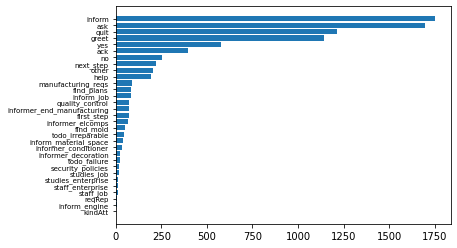

In [ ]:
counts_loria = count_labels(loria['train']['Label'])

plt.barh(y=list(counts_loria.keys()), width=counts_loria.values())
plt.yticks(fontsize=7)

plt.show()

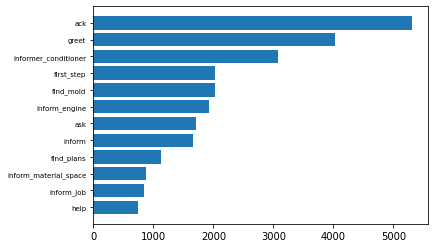

In [ ]:
counts_maptask = count_labels(maptask['train']['Label'])

plt.barh(y=list(counts_maptask.keys()), width=counts_maptask.values())
plt.yticks(fontsize=7)

plt.show()

In [ ]:
# nb of labels per utterance : 
print(f"Maptask has on average {round(maptask['train'].num_rows / len(maptask['train'].features['Label'].names),0)} utterances per label")
print(f"Loria has on average {round(loria['train'].num_rows / len(loria['train'].features['Label'].names),0)} utterances per label")

Maptask has on average 2115.0 utterances per label
Loria has on average 273.0 utterances per label


### Data preprocessing of Loria and Maptask

#### Cumulative concatenation of the utterances within each dialog


In [ ]:
def create_cum_all_dialog_utterances(data):
  for key in data:
    # extract label names
    labels_names = data[key].features['Label'].names

    # convert to dataframe
    df = data[key].to_pandas()
      
    # group by Dialog
    grouped_data = df.groupby('Dialogue_ID')
      
    # Cumulatively concatenate utterances in a new column
    df['Utterance_dialog_cum'] = grouped_data['Utterance'].transform(lambda x: x.add('</s>').cumsum()).str.rstrip()
        
    # switch back to dataset format
    features = Features({'Speaker': Value(dtype='string', id=None),
                        'Utterance': Value(dtype='string', id=None),
                        'Dialogue_Act': Value(dtype='string', id=None),
                        'Dialogue_ID': Value(dtype='string', id=None),
                        'File_ID': Value(dtype='string', id=None),
                        'Label': ClassLabel(names=labels_names, id=None),
                           'Idx': Value(dtype='int32', id=None),
                           'Utterance_cum': Value(dtype='string', id=None)})
      
    data[key] = Dataset.from_pandas(df, features=features)

  #return data

In [ ]:
def concat_last_three(df):
    # initialize a list to store the concatenated utterances
    concatenated = []
    # loop through each row
    for i in range(len(df)):
        # get the previous three utterances (if available)
        prev_utterances = df['Utterance'].iloc[max(0, i-2):i+1]
        # concatenate the utterances and add to the list
        concatenated.append('. '.join(prev_utterances))
    # return the concatenated utterances
    return pd.Series(concatenated)

def create_cum_3last_utterances(data):
  for key in data:
    # extract label names
    labels_names = data[key].features['Label'].names

    # convert to dataframe
    df = data[key].to_pandas()
      
    # apply the function to each group in 'dialog' column and create a new column
    #df['Utterance_dialog_switchspeaker_cum'] = df.groupby('Dialogue_ID').apply(concat_last_three).explode()
    df['Utterance_3last_cum'] = df.groupby('Dialogue_ID').apply(concat_last_three).reset_index(drop=True)

        
    # switch back to dataset format
    features = Features({'Speaker': Value(dtype='string', id=None),
                        'Utterance': Value(dtype='string', id=None),
                        'Dialogue_Act': Value(dtype='string', id=None),
                        'Dialogue_ID': Value(dtype='string', id=None),
                        'File_ID': Value(dtype='string', id=None),
                        'Label': ClassLabel(names=labels_names, id=None),
                           'Idx': Value(dtype='int32', id=None),
                           'Utterance_3last_cum': Value(dtype='string', id=None)})
      
    data[key] = Dataset.from_pandas(df, features=features)

  #return data

In [ ]:
create_cum_3last_utterances(loria)
create_cum_3last_utterances(maptask)

#### Tokenization of the whole dataset

In [ ]:
def tokenizer_concat_XLMRoB_function(examples):
    return tokenizer_XLMRoB(examples["Utterance_3last_cum"], truncation=True)

In [ ]:
def tokenizer_XLMRoB_function(examples):
    return tokenizer_XLMRoB(examples["Utterance"], truncation=True)

In [ ]:
def tokenizer_CamB_function(examples):
    return tokenizer_CamB(examples["Utterance"], truncation=True)

In [ ]:
loria["train"].column_names
assert(maptask["train"].column_names ==loria["train"].column_names)

##### Tokenization for concatenated data

In [ ]:
tokenized_loria_XLMRoB_concat = loria.map(tokenizer_concat_XLMRoB_function, batched=True,
                            remove_columns=['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Idx', 'Utterance_3last_cum'])

tokenized_loria_XLMRoB_concat = tokenized_loria_XLMRoB_concat.rename_column("Label", "labels")

Map:   0%|          | 0/8465 [00:00<?, ? examples/s]

Map:   0%|          | 0/942 [00:00<?, ? examples/s]

Map:   0%|          | 0/1047 [00:00<?, ? examples/s]

In [ ]:
tokenized_maptask_XLMRoB_concat = maptask.map(tokenizer_concat_XLMRoB_function, batched=True,
                            remove_columns=['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Idx', 'Utterance_3last_cum'])

tokenized_maptask_XLMRoB_concat = tokenized_maptask_XLMRoB_concat.rename_column("Label", "labels")

Map:   0%|          | 0/25382 [00:00<?, ? examples/s]

Map:   0%|          | 0/5221 [00:00<?, ? examples/s]

Map:   0%|          | 0/5335 [00:00<?, ? examples/s]

In [ ]:
tokenized_loria_XLMRoB_concat.set_format("torch")
tokenized_maptask_XLMRoB_concat.set_format("torch")

In [ ]:
tokenized_loria_XLMRoB_concat['train'][0:2]

{'labels': tensor([5, 1]),
 'input_ids': [tensor([    0, 43908,    38,     2]),
  tensor([    0, 43908,    38,     5,   891,  9937,    41,   370, 24215,     7,
             96,    25, 37276,     8,    96,    25, 58294,     8, 14015,   474,
          16857,     2])],
 'attention_mask': [tensor([1, 1, 1, 1]),
  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]}

In [ ]:
tokenized_maptask_XLMRoB_concat['train'][0:2]

{'labels': tensor([5, 0]),
 'input_ids': [tensor([     0,  68403,     70,   4034,   2831,     83,     99,     70,   2663,
           25737,      9,  12336, 107767,      2]),
  tensor([     0,  68403,     70,   4034,   2831,     83,     99,     70,   2663,
           25737,      9,  12336, 107767,      5,  38074,      9,   1132,    127,
               2])],
 'attention_mask': [tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]}

In [ ]:
# let's see to what each token id correspond to : we can indeed so the speical token <s> at the end and begining of sentence
tokens = tokenizer_XLMRoB.convert_ids_to_tokens(tokenized_loria_XLMRoB_concat['train']['input_ids'][4])
print(tokens)

['<s>', '▁O', 'ù', '▁est', '▁l', "'", 'entreprise', '▁qu', "'", 'on', '▁cherche', '▁?', '.', '▁Je', '▁ne', '▁sais', '▁pas', '...', '▁mon', '▁on', 'cle', '▁a', '▁dit', '▁que', '▁c', "'", '▁était', '▁quelque', '▁part', '▁dans', '▁ce', '▁labo', '.', '▁Il', '▁faut', '▁fou', 'iller', '.', '▁Regard', 'e', '▁voir', '▁près', '▁du', '▁tableau', '▁noir', '▁là', '▁bas', '.', '.', '▁Alle', 'z', '!', '</s>']


##### Tokenization for non concatenated data (Utterances taken independently)

In [ ]:
tokenized_loria_XLMRoB_simple = loria.map(tokenizer_XLMRoB_function, batched=True,
                            remove_columns=['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Idx', 'Utterance_3last_cum'])

tokenized_loria_XLMRoB_simple = tokenized_loria_XLMRoB_simple.rename_column("Label", "labels")

Map:   0%|          | 0/8465 [00:00<?, ? examples/s]

Map:   0%|          | 0/942 [00:00<?, ? examples/s]

Map:   0%|          | 0/1047 [00:00<?, ? examples/s]

In [ ]:
tokenized_maptask_XLMRoB_simple = maptask.map(tokenizer_XLMRoB_function, batched=True,
                            remove_columns=['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Idx', 'Utterance_3last_cum'])

tokenized_maptask_XLMRoB_simple = tokenized_maptask_XLMRoB_simple.rename_column("Label", "labels")

Map:   0%|          | 0/25382 [00:00<?, ? examples/s]

Map:   0%|          | 0/5221 [00:00<?, ? examples/s]

Map:   0%|          | 0/5335 [00:00<?, ? examples/s]

In [ ]:
tokenized_loria_CamB_simple = loria.map(tokenizer_CamB_function, batched=True,
                            remove_columns=['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Idx'])

tokenized_loria_CamB_simple = tokenized_loria_CamB_simple.rename_column("Label", "labels")

Map:   0%|          | 0/8465 [00:00<?, ? examples/s]

Map:   0%|          | 0/942 [00:00<?, ? examples/s]

Map:   0%|          | 0/1047 [00:00<?, ? examples/s]

In [ ]:
tokenized_loria_XLMRoB_simple.set_format("torch")
tokenized_maptask_XLMRoB_simple.set_format("torch")
tokenized_loria_CamB_simple.set_format("torch")

In [ ]:
tokenized_loria_XLMRoB_simple['train'][0:2]

{'labels': tensor([5, 1]),
 'input_ids': [tensor([    0, 43908,    38,     2]),
  tensor([    0,   891,  9937,    41,   370, 24215,     7,    96,    25, 37276,
              8,    96,    25, 58294,     8, 14015,   474, 16857,     2])],
 'attention_mask': [tensor([1, 1, 1, 1]),
  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]}

In [ ]:
tokenized_maptask_XLMRoB_simple['train'][0:2]

{'labels': tensor([5, 0]),
 'input_ids': [tensor([     0,  68403,     70,   4034,   2831,     83,     99,     70,   2663,
           25737,      9,  12336, 107767,      2]),
  tensor([    0, 38074,     9,  1132,   127,     2])],
 'attention_mask': [tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  tensor([1, 1, 1, 1, 1, 1])]}

In [ ]:
tokenized_loria_CamB_simple['train'][0:2]

{'labels': tensor([5, 1]),
 'Utterance_3last_cum': ['Alors!',
  "Alors!. Il faut que tu trouves l' adresse de l' entreprise de plasturgie"],
 'input_ids': [tensor([  5, 574, 152,   6]),
  tensor([    5,    69,   213,    27,   150,   396,    10,    17,    11,  1854,
              8,    17,    11,   814,     8,    21, 19949,   297,  3909,     6])],
 'attention_mask': [tensor([1, 1, 1, 1]),
  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]}

##### Padding sentences to the longest length in a batch

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer_XLMRoB)

#### Check that the max length of Cumulative utterances is within with the max length capacity of RoBERTa

In [ ]:
from transformers import XLMRobertaConfig
configuration = XLMRobertaConfig()
print(f"XLM RobERTa max sequence legnth is {configuration.max_position_embeddings}")

XLM RobERTa max sequence legnth is 512


In [ ]:
def compute_utterance_concat_length(example):
    return {"Utterance_cum_length": len(example['input_ids'])}

In [ ]:
len_concat_token_maptask = tokenized_maptask_XLMRoB_concat.map(compute_utterance_concat_length)
len_concat_token_loria = tokenized_loria_XLMRoB_concat.map(compute_utterance_concat_length)

Map:   0%|          | 0/25382 [00:00<?, ? examples/s]

Map:   0%|          | 0/5221 [00:00<?, ? examples/s]

Map:   0%|          | 0/5335 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask', 'Utterance_cum_length'],
        num_rows: 25382
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask', 'Utterance_cum_length'],
        num_rows: 5221
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask', 'Utterance_cum_length'],
        num_rows: 5335
    })
})

In [ ]:
len_concat_token_maptask['train'][0:3]

{'labels': tensor([5, 0, 1]),
 'input_ids': [tensor([     0,  68403,     70,   4034,   2831,     83,     99,     70,   2663,
           25737,      9,  12336, 107767,      2]),
  tensor([     0,  68403,     70,   4034,   2831,     83,     99,     70,   2663,
           25737,      9,  12336, 107767,      5,  38074,      9,   1132,    127,
               2]),
  tensor([     0,  68403,     70,   4034,   2831,     83,     99,     70,   2663,
           25737,      9,  12336, 107767,      5,  38074,      9,   1132,    127,
               5,  68403,      2])],
 'attention_mask': [tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])],
 'Utterance_cum_length': tensor([14, 19, 21])}

In [ ]:
len_concat_token_loria['train'][0:3]

{'labels': tensor([5, 1, 6]),
 'input_ids': [tensor([    0, 43908,    38,     2]),
  tensor([    0, 43908,    38,     5,   891,  9937,    41,   370, 24215,     7,
             96,    25, 37276,     8,    96,    25, 58294,     8, 14015,   474,
          16857,     2]),
  tensor([    0, 43908,    38,     5,   891,  9937,    41,   370, 24215,     7,
             96,    25, 37276,     8,    96,    25, 58294,     8, 14015,   474,
          16857,     5,   180,  8612,   437,    96,    25, 49801,  1103,    25,
            191, 92286,   705,     2])],
 'attention_mask': [tensor([1, 1, 1, 1]),
  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1])],
 'Utterance_cum_length': tensor([ 4, 22, 34])}

The longest utterance of are under 200 tokens for Loria, and Maptask, which is well under the 512 max length sequence of XLM Roberta

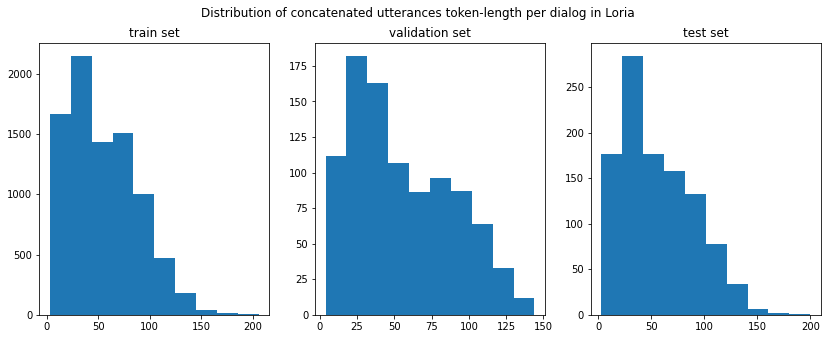

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(14,5))

axes[0].hist(len_concat_token_loria["train"]['Utterance_cum_length'])
axes[1].hist(len_concat_token_loria["validation"]['Utterance_cum_length'])
axes[2].hist(len_concat_token_loria["test"]['Utterance_cum_length'])

axes[0].set_title('train set')
axes[1].set_title('validation set')
axes[2].set_title('test set')

fig.suptitle('Distribution of concatenated utterances token-length per dialog in Loria')

plt.show()

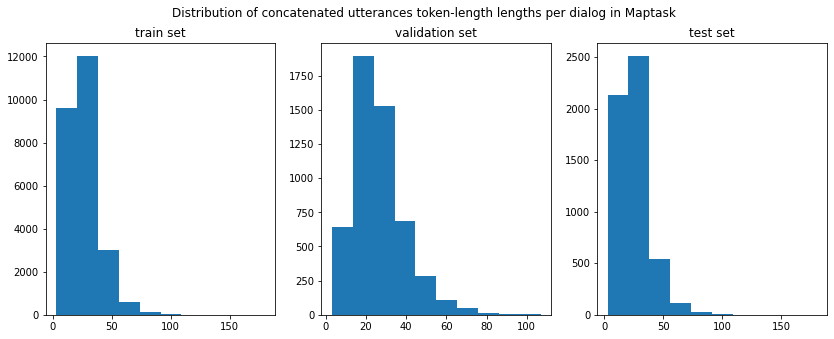

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(14,5))

axes[0].hist(len_concat_token_maptask["train"]['Utterance_cum_length'])
axes[1].hist(len_concat_token_maptask["validation"]['Utterance_cum_length'])
axes[2].hist(len_concat_token_maptask["test"]['Utterance_cum_length'])

axes[0].set_title('train set')
axes[1].set_title('validation set')
axes[2].set_title('test set')

fig.suptitle('Distribution of concatenated utterances token-length lengths per dialog in Maptask')

plt.show()

### Fine tune pre-trained model and their classification head for the downstream task of Dialog Act identification

* XLM RoBERTA for Loria and Maptask
  * with or without concatenation of last 3 Utterances
* CamemBERT for Loria. No concatenation

[XLMRobertaForSequenceClassification documentation](https://huggingface.co/docs/transformers/v4.26.1/en/model_doc/xlm-roberta#transformers.XLMRobertaForSequenceClassification): classification head :a linear layer on top of the pooled outputfrom the pre-trained model. That is to say, the XLM Roberta encoder outputs a 768 long embedding, which is mapped to a new layer where the number of neurons equals the number of possible labels



##### Padding sentences to the longest length in a batch

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer_XLMRoB)
data_collator_camB = DataCollatorWithPadding(tokenizer=tokenizer_CamB)

##### Defining metrics

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
recall = evaluate.load("recall")
precision = evaluate.load("precision")

In [ ]:
import numpy as np

# The difference between macro and micro averaging is that macro averaging gives equal weight to each category 
# We use macro average scores when we need to treat all classes equally to evaluate the overall performance of the classifier

# While micro averaging gives equal weight to each sample. 

# If we have the same number of samples for each class, both macro and micro will provide the same score.

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)
    f1_micro_score = f1.compute(predictions=predictions, references=labels, average='micro')
    f1_macro_score = f1.compute(predictions=predictions, references=labels, average='macro')
    recall_micro_score = recall.compute(predictions=predictions, references=labels, average='micro')
    return {'Accuracy': accuracy_score,
            'F1_micro': f1_micro_score,
            'F1_macro': f1_macro_score,
            'Recall': recall_micro_score}

#### Importing Sequence classification models

In [ ]:
from transformers import XLMRobertaForSequenceClassification,  CamembertForSequenceClassification, TrainingArguments, Trainer

model_CamB = CamembertForSequenceClassification.from_pretrained('camembert-base',
                                                                num_labels=num_label_loria,
                                                                problem_type="single_label_classification",
                                                                id2label=id2label_loria,
                                                                label2id=label2id_loria) 

model_XLMRoB_loria = XLMRobertaForSequenceClassification.from_pretrained(checkpoint,
                                                                         problem_type="single_label_classification", 
                                                                         num_labels=num_label_loria, 
                                                                         id2label=id2label_loria, 
                                                                         label2id=label2id_loria) 

model_XLMRoB_maptask = XLMRobertaForSequenceClassification.from_pretrained(checkpoint,
                                                                           problem_type="single_label_classification",
                                                                           num_labels=num_label_maptask,
                                                                           id2label=id2label_maptask,
                                                                           label2id=label2id_maptask) 

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.weig

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [ ]:
# test a forward pass just to see what's happening : 
  # it outputs a vector 31 logits (1 for each label)
  
outputs = model_XLMRoB_loria(input_ids=tokenized_loria_XLMRoB_simple['train']['input_ids'][0].unsqueeze(0), labels=tokenized_loria_XLMRoB_simple['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(3.5251, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.0456, -0.0256, -0.0936,  0.0298, -0.0716, -0.1202, -0.2500,  0.3992,
          0.0474, -0.0600,  0.0685, -0.3585,  0.1437,  0.0102,  0.2219, -0.1211,
         -0.1570, -0.4302, -0.2970,  0.0909, -0.2130,  0.0642, -0.0624, -0.1204,
         -0.0062, -0.1935, -0.3620,  0.0172,  0.1541, -0.0130,  0.2426]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
# BESOIN DE CUSTOMISER LE TRAIN POUR METTRE DES POIDS SUR LA LOSS ET PRENDRE EN COMPTE IMBALANCE DES LABELS ?
# https://huggingface.co/docs/transformers/main_classes/trainer 

#### Training loop

In [ ]:
# we use the Trainer class provided by HuggingFace in the transformers library
training_args = TrainingArguments(
    output_dir='model',
    learning_rate=5e-5,
    num_train_epochs=1, # 1 epoch, will be used for Roberta which is bigger and more resources demanding to train..
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [ ]:
training_args_cam = TrainingArguments(
    output_dir='model',
    learning_rate=5e-5,
    num_train_epochs=3, 
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [ ]:
trainer_CamB_loria_simple = Trainer(
    model=model_CamB,
    args=training_args_cam,
    train_dataset=tokenized_loria_CamB_simple["train"],
    eval_dataset=tokenized_loria_CamB_simple["validation"],
    tokenizer=tokenizer_CamB,
    data_collator=data_collator_camB,
    compute_metrics=compute_metrics,
)

trainer_CamB_loria_simple.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Recall
1,0.738800,0.707077,{'accuracy': 0.8089171974522293},{'f1': 0.8089171974522293},{'f1': 0.2700652051364497},{'recall': 0.8089171974522293}
2,0.568700,0.634540,{'accuracy': 0.8375796178343949},{'f1': 0.8375796178343949},{'f1': 0.3732957284729746},{'recall': 0.8375796178343949}
3,0.446200,0.575725,{'accuracy': 0.8588110403397028},{'f1': 0.8588110403397028},{'f1': 0.4069772246136989},{'recall': 0.8588110403397028}


Trainer is attempting to log a value of "{'accuracy': 0.8089171974522293}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8089171974522293}" of type <class 'dict'> for key "eval/F1_micro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.2700652051364497}" of type <class 'dict'> for key "eval/F1_macro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.8089171974522293}" of type <class 'dict'> for key "eval/Recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8375796178343949}" of type <class 'd

TrainOutput(global_step=3177, training_loss=0.6238574951671376, metrics={'train_runtime': 404.4345, 'train_samples_per_second': 62.791, 'train_steps_per_second': 7.855, 'total_flos': 655388563579134.0, 'train_loss': 0.6238574951671376, 'epoch': 3.0})

In [ ]:
trainer_XLMRoB_loria_concat = Trainer(
    model=model_XLMRoB_loria,
    args=training_args,
    train_dataset=tokenized_loria_XLMRoB_concat["train"],
    eval_dataset=tokenized_loria_XLMRoB_concat["validation"],
    tokenizer=tokenizer_XLMRoB,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_XLMRoB_loria_concat.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Recall
1,2.399200,2.399169,{'accuracy': 0.21019108280254778},{'f1': 0.21019108280254778},{'f1': 0.011978221415607986},{'recall': 0.21019108280254778}


Trainer is attempting to log a value of "{'accuracy': 0.21019108280254778}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.21019108280254778}" of type <class 'dict'> for key "eval/F1_micro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.011978221415607986}" of type <class 'dict'> for key "eval/F1_macro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.21019108280254778}" of type <class 'dict'> for key "eval/Recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=1059, training_loss=2.4503356962411105, metrics={'train_runtime': 307.1091, 'train_samples_per_second': 27.563, 'train_steps_per_second': 3.448, 'total_flos': 464072955228036.0, 'train_loss': 2.4503356962411105, 'epoch': 1.0})

In [ ]:
trainer_XLMRoB_loria_simple = Trainer(
    model=model_XLMRoB_loria,
    args=training_args,
    train_dataset=tokenized_loria_XLMRoB_simple["train"],
    eval_dataset=tokenized_loria_XLMRoB_simple["validation"],
    tokenizer=tokenizer_XLMRoB,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_XLMRoB_loria_simple.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Recall
1,1.035300,0.956417,{'accuracy': 0.7176220806794055},{'f1': 0.7176220806794055},{'f1': 0.15702713450961076},{'recall': 0.7176220806794055}


Trainer is attempting to log a value of "{'accuracy': 0.7176220806794055}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7176220806794055}" of type <class 'dict'> for key "eval/F1_micro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.15702713450961076}" of type <class 'dict'> for key "eval/F1_macro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.7176220806794055}" of type <class 'dict'> for key "eval/Recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=1059, training_loss=1.355302333381516, metrics={'train_runtime': 236.0532, 'train_samples_per_second': 35.861, 'train_steps_per_second': 4.486, 'total_flos': 241598325758790.0, 'train_loss': 1.355302333381516, 'epoch': 1.0})

In [ ]:
trainer_XLMRoB_maptask_concat = Trainer(
    model=model_XLMRoB_maptask,
    args=training_args,
    train_dataset=tokenized_maptask_XLMRoB_concat["train"],
    eval_dataset=tokenized_maptask_XLMRoB_concat["validation"],
    tokenizer=tokenizer_XLMRoB,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_XLMRoB_maptask_concat.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Recall
1,2.320200,2.337782,{'accuracy': 0.18866117601991955},{'f1': 0.18866117601991952},{'f1': 0.0264528950478032},{'recall': 0.18866117601991955}


Trainer is attempting to log a value of "{'accuracy': 0.18866117601991955}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.18866117601991952}" of type <class 'dict'> for key "eval/F1_micro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.0264528950478032}" of type <class 'dict'> for key "eval/F1_macro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.18866117601991955}" of type <class 'dict'> for key "eval/Recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=3173, training_loss=2.31986323854655, metrics={'train_runtime': 632.0569, 'train_samples_per_second': 40.158, 'train_steps_per_second': 5.02, 'total_flos': 616288142927520.0, 'train_loss': 2.31986323854655, 'epoch': 1.0})

In [ ]:
trainer_XLMRoB_maptask_simple = Trainer(
    model=model_XLMRoB_maptask,
    args=training_args,
    train_dataset=tokenized_maptask_XLMRoB_simple["train"],
    eval_dataset=tokenized_maptask_XLMRoB_simple["validation"],
    tokenizer=tokenizer_XLMRoB,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_XLMRoB_maptask_simple.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Recall
1,1.115100,1.065124,{'accuracy': 0.6349358360467343},{'f1': 0.6349358360467343},{'f1': 0.5544978124142932},{'recall': 0.6349358360467343}


Trainer is attempting to log a value of "{'accuracy': 0.6349358360467343}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6349358360467343}" of type <class 'dict'> for key "eval/F1_micro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.5544978124142932}" of type <class 'dict'> for key "eval/F1_macro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.6349358360467343}" of type <class 'dict'> for key "eval/Recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=3173, training_loss=1.3248746903807516, metrics={'train_runtime': 591.9868, 'train_samples_per_second': 42.876, 'train_steps_per_second': 5.36, 'total_flos': 306535455164160.0, 'train_loss': 1.3248746903807516, 'epoch': 1.0})

Score F1 micro correct mais pas macro : cela veut surêment dire qu'on a un label qui est très présent et qu'on arrive bien à prédire, mais sinon on prédit mal d'autres labels + rares

In [ ]:
# trainer.save_model("XLMRo1")

In [ ]:
# model_XLMRoB = XLMRobertaForSequenceClassification.from_pretrained("XLMRo1")

In [ ]:
# if we want to look at the content of the model : the tokenizer, the encoder (12 layers or 'blocs' of transformer encoder architecture), 
# and then the classification head made of a dense layer, a dropout and a layer reduction from 768 to 31 outputs

#model_XLMRoB

### Tester les prédiction du modèle sur le test set, et sur des phrases créées

In [ ]:
# à revoir: ici par défaut l'execution est sur le validation set, pas le test set
# trainer_XLMRoB_loria_concat.evaluate()

In [ ]:
results_loria_concat = trainer_XLMRoB_loria_concat.predict(tokenized_loria_XLMRoB_concat["test"])
results_loria_simple = trainer_XLMRoB_loria_simple.predict(tokenized_loria_XLMRoB_simple["test"])

NameError: ignored

In [ ]:
results_maptask_concat = trainer_XLMRoB_maptask_concat.predict(tokenized_maptask_XLMRoB_concat["test"])
results_maptask_simple = trainer_XLMRoB_maptask_simple.predict(tokenized_maptask_XLMRoB_simple["test"])

In [ ]:
results_CamB_loria_simple = trainer_CamB_loria_simple.predict(tokenized_loria_CamB_simple["test"])

In [ ]:
results_loria_concat.metrics

{'test_loss': 4.563905239105225,
 'test_Accuracy': {'accuracy': 0.17860553963705827},
 'test_F1_micro': {'f1': 0.1786055396370583},
 'test_F1_macro': {'f1': 0.029797703299077723},
 'test_Recall': {'recall': 0.17860553963705827},
 'test_runtime': 6.6468,
 'test_samples_per_second': 157.52,
 'test_steps_per_second': 19.709}

In [ ]:
results_loria_simple.metrics

{'test_loss': 0.9103154540061951,
 'test_Accuracy': {'accuracy': 0.7440305635148042},
 'test_F1_micro': {'f1': 0.7440305635148042},
 'test_F1_macro': {'f1': 0.18480918577502775},
 'test_Recall': {'recall': 0.7440305635148042},
 'test_runtime': 4.1886,
 'test_samples_per_second': 249.967,
 'test_steps_per_second': 31.276}

In [ ]:
results_maptask_concat.metrics

{'test_loss': 2.3035929203033447,
 'test_Accuracy': {'accuracy': 0.2148078725398313},
 'test_F1_micro': {'f1': 0.2148078725398313},
 'test_F1_macro': {'f1': 0.029470760685079464},
 'test_Recall': {'recall': 0.2148078725398313},
 'test_runtime': 23.9279,
 'test_samples_per_second': 222.962,
 'test_steps_per_second': 27.875}

In [ ]:
results_maptask_simple.metrics

{'test_loss': 1.0946285724639893,
 'test_Accuracy': {'accuracy': 0.633552014995314},
 'test_F1_micro': {'f1': 0.633552014995314},
 'test_F1_macro': {'f1': 0.5465916310359512},
 'test_Recall': {'recall': 0.633552014995314},
 'test_runtime': 10.2094,
 'test_samples_per_second': 522.559,
 'test_steps_per_second': 65.332}

In [ ]:
results_CamB_loria_simple.metrics

{'test_loss': 0.5194748044013977,
 'test_Accuracy': {'accuracy': 0.8624641833810889},
 'test_F1_micro': {'f1': 0.8624641833810889},
 'test_F1_macro': {'f1': 0.4749393045445872},
 'test_Recall': {'recall': 0.8624641833810889},
 'test_runtime': 3.7004,
 'test_samples_per_second': 282.94,
 'test_steps_per_second': 35.401}

In [ ]:
preds_loria_concat = np.argmax(results_loria_concat.predictions, axis=-1)
preds_loria_simple = np.argmax(results_loria_simple.predictions, axis=-1)

In [ ]:
preds_maptask_concat = np.argmax(results_maptask_concat.predictions, axis=-1)
preds_maptask_simple = np.argmax(results_maptask_simple.predictions, axis=-1)

In [ ]:
preds_loria_camB_simple = np.argmax(results_CamB_loria_simple.predictions, axis=-1)

In [ ]:
labelid_loria_test = set(loria['test']['Label'])
labelnames_loria_test = [id2label_loria[k] for k in labelid_loria_test]

labelid_maptask_test = set(maptask['test']['Label'])
labelnames_maptask_test = [id2label_maptask[k] for k in labelid_maptask_test]

In [ ]:
print(classification_report(preds_loria_concat, loria['test']['Label'], target_names=labelnames_loria_test))

                            precision    recall  f1-score   support

                       ack       0.00      0.00      0.00         0
                       ask       0.00      0.00      0.00         0
                 find_mold       0.00      0.00      0.00         0
                find_plans       0.00      0.00      0.00         0
                first_step       0.00      0.00      0.00         0
                     greet       0.00      0.00      0.00         0
                      help       0.00      0.00      0.00         0
                    inform       1.00      0.21      0.34      1047
                inform_job       0.00      0.00      0.00         0
     inform_material_space       0.00      0.00      0.00         0
      informer_conditioner       0.00      0.00      0.00         0
       informer_decoration       0.00      0.00      0.00         0
          informer_elcomps       0.00      0.00      0.00         0
informer_end_manufacturing       0.00      0.00

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(preds_loria_simple, loria['test']['Label'], target_names=labelnames_loria_test))

                            precision    recall  f1-score   support

                       ack       0.04      0.67      0.08         3
                       ask       0.97      0.90      0.93       232
                 find_mold       0.00      0.00      0.00         0
                find_plans       0.00      0.00      0.00         0
                first_step       0.00      0.00      0.00         0
                     greet       0.92      0.96      0.94       135
                      help       0.00      0.00      0.00         1
                    inform       0.98      0.94      0.96       228
                inform_job       0.00      0.00      0.00         0
     inform_material_space       0.00      0.00      0.00         0
      informer_conditioner       0.00      0.00      0.00         0
       informer_decoration       0.00      0.00      0.00         0
          informer_elcomps       0.00      0.00      0.00         0
informer_end_manufacturing       0.00      0.00

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(preds_maptask_concat, maptask['test']['Label'], target_names=labelnames_maptask_test))

              precision    recall  f1-score   support

 acknowledge       1.00      0.21      0.35      5335
       align       0.00      0.00      0.00         0
       check       0.00      0.00      0.00         0
     clarify       0.00      0.00      0.00         0
     explain       0.00      0.00      0.00         0
    instruct       0.00      0.00      0.00         0
     query_w       0.00      0.00      0.00         0
    query_yn       0.00      0.00      0.00         0
       ready       0.00      0.00      0.00         0
     reply_n       0.00      0.00      0.00         0
     reply_w       0.00      0.00      0.00         0
     reply_y       0.00      0.00      0.00         0

    accuracy                           0.21      5335
   macro avg       0.08      0.02      0.03      5335
weighted avg       1.00      0.21      0.35      5335



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(preds_maptask_simple, maptask['test']['Label'], target_names=labelnames_maptask_test))

              precision    recall  f1-score   support

 acknowledge       0.69      0.64      0.66      1243
       align       0.31      0.62      0.41       137
       check       0.53      0.39      0.45       640
     clarify       0.01      0.25      0.01         8
     explain       0.76      0.58      0.66       565
    instruct       0.88      0.67      0.76      1111
     query_w       0.81      0.77      0.79       147
    query_yn       0.71      0.77      0.74       328
       ready       0.43      0.81      0.56       213
     reply_n       0.93      0.72      0.81       243
     reply_w       0.00      0.00      0.00         0
     reply_y       0.74      0.66      0.69       700

    accuracy                           0.63      5335
   macro avg       0.57      0.57      0.55      5335
weighted avg       0.72      0.63      0.67      5335



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


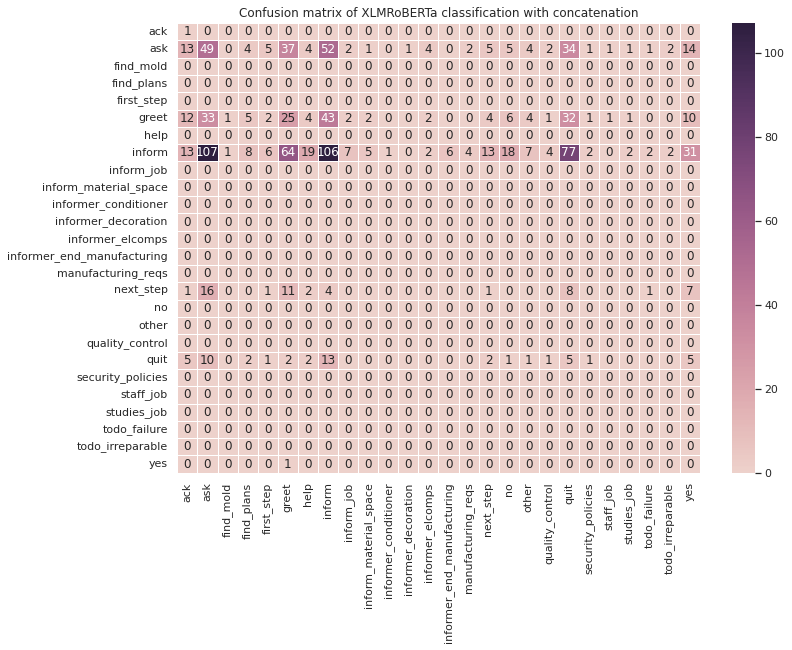

In [ ]:
cm = confusion_matrix(preds_loria_concat, loria['test']['Label'])
df_cm = pd.DataFrame(cm, index=labelnames_loria_test, columns=labelnames_loria_test)
# config plot sizes
sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap=sn.cubehelix_palette(as_cmap=True), linewidth=0.5, fmt="")

plt.title('Confusion matrix of XLMRoBERTa classification with concatenation')
plt.show()

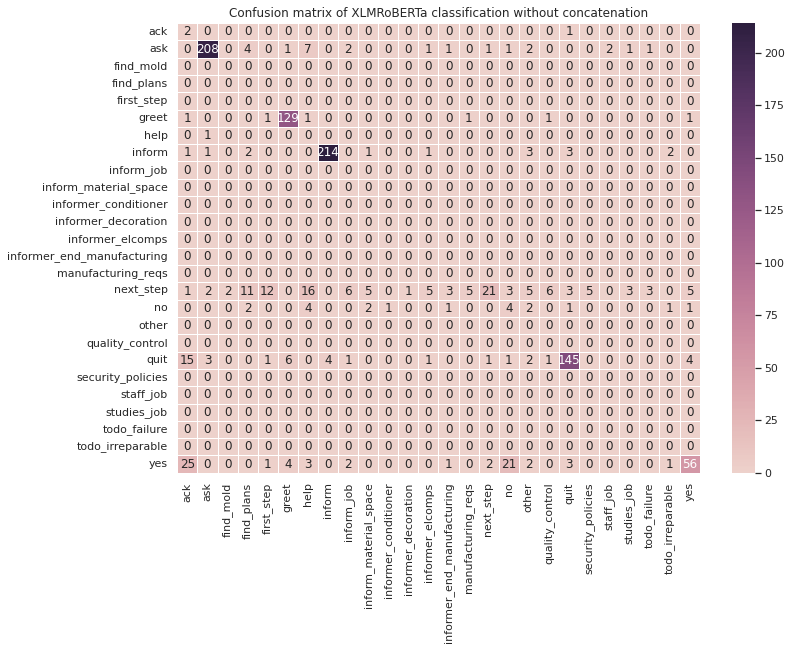

In [ ]:
cm = confusion_matrix(preds_loria_simple, loria['test']['Label'])
df_cm = pd.DataFrame(cm, index=labelnames_loria_test, columns=labelnames_loria_test)
# config plot sizes
sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap=sn.cubehelix_palette(as_cmap=True), linewidth=0.5, fmt="")

plt.title('Confusion matrix of XLMRoBERTa classification without concatenation')
plt.show()

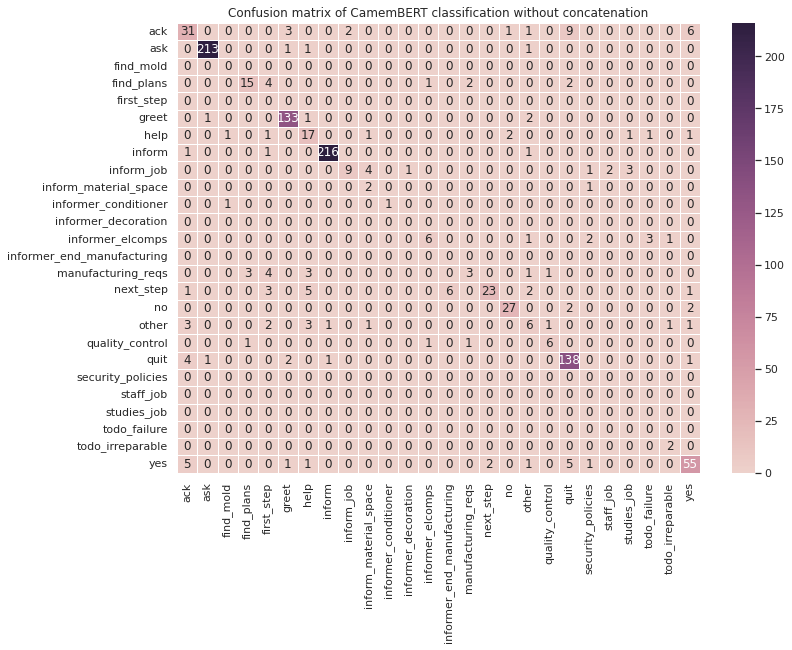

In [ ]:
cm = confusion_matrix(preds_loria_camB_simple, loria['test']['Label'])
df_cm = pd.DataFrame(cm, index=labelnames_loria_test, columns=labelnames_loria_test)
# config plot sizes
sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap=sn.cubehelix_palette(as_cmap=True), linewidth=0.5, fmt="")

plt.title('Confusion matrix of CamemBERT classification without concatenation')
plt.show()

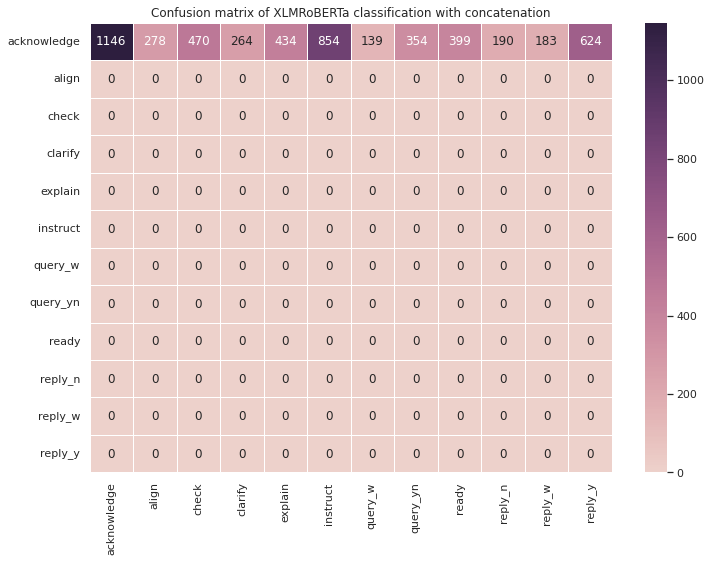

In [ ]:
cm = confusion_matrix(preds_maptask_concat, maptask['test']['Label'])
df_cm = pd.DataFrame(cm, index=labelnames_maptask_test, columns=labelnames_maptask_test)
# config plot sizes
sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap=sn.cubehelix_palette(as_cmap=True), linewidth=0.5, fmt="")

plt.title('Confusion matrix of XLMRoBERTa classification with concatenation')
plt.show()

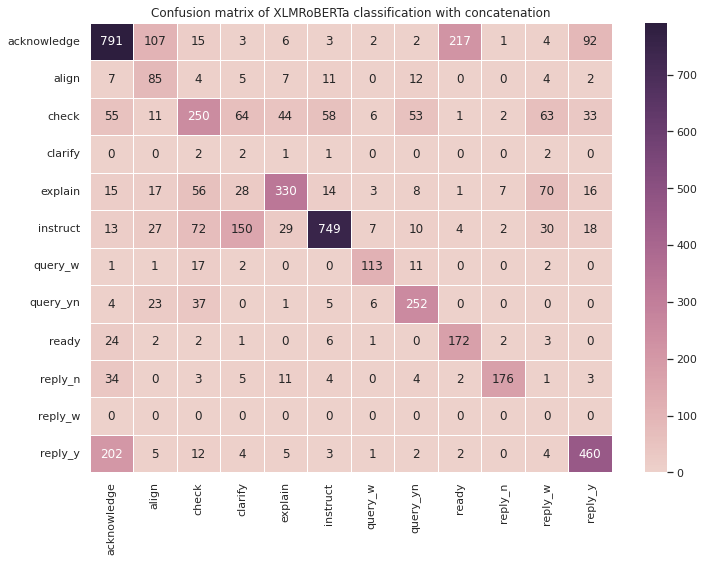

In [ ]:
cm = confusion_matrix(preds_maptask_simple, maptask['test']['Label'])
df_cm = pd.DataFrame(cm, index=labelnames_maptask_test, columns=labelnames_maptask_test)
# config plot sizes
sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap=sn.cubehelix_palette(as_cmap=True), linewidth=0.5, fmt="")

plt.title('Confusion matrix of XLMRoBERTa classification with concatenation')
plt.show()

### Let's test the model on a few sentences:

In [ ]:
from transformers import pipeline  

In [ ]:
model_XLMRoB_loria

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0): XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tr

In [ ]:
test = "Hello, my name is Bryan"
test2 = "What is the time of yesterday"

In [ ]:
def tokenizer(example):
  tokenizer_XLMRoB(example, return_tensors="pt")


In [ ]:
encoding = tokenizer_XLMRoB(test, return_tensors="pt")

In [ ]:
 encoding.items()

dict_items([('input_ids', tensor([[     0,  35378,      4,    759,   9351,     83, 153095,      2]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1, 1, 1]]))])

In [ ]:
encoding = {k: v.to(trainer_XLMRoB_loria_simple.model.device) for k,v in encoding.items()}

outputs = trainer_XLMRoB_loria_simple.model(**encoding)

In [ ]:
encoding

{'input_ids': tensor([[     0,  35378,      4,    759,   9351,     83, 153095,      2]],
        device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [ ]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 1.5853, -1.5263, -0.4675, -0.2255, -0.6411,  3.5104,  0.7292, -1.3982,
         -1.1120,  0.0225, -0.4147, -0.6383, -0.9060, -0.3420, -0.2720, -1.2568,
         -0.6452,  0.4052,  1.5053,  0.4604, -0.4054,  0.3993, -1.4438, -1.4904,
         -1.2639, -1.5353, -1.1088, -1.2225, -0.9455, -0.5791,  1.8393]],
       device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
logits = outputs.logits
logits.shape

torch.Size([1, 31])

In [ ]:
prediction = np.argmax(logits.detach().cpu(), axis=1).item()
label_prediction = id2label_loria[prediction]

print(f"Our model thinks that '{test}' is a Dialog Act of kind '{label_prediction}'.")

Our model thinks that 'Hello, my name is Bryan' is a Dialog Act of kind 'greet'.
